
This notebook demonstrates how to create an analysis ready spatialite database for borehoel data. All data has been processed filtered and the depths corrected onto to metres below ground level. Induction and gamma data are resampled to 5cm intervals and are on the same table.

Neil Symington neil.symington@ga.gov.au

In [1]:
import shapely.wkb
import shapely.wkt
from shapely.geometry import Point
import os, glob
import pandas as pd
# sqlite/spatialite
from sqlalchemy import create_engine, event, ForeignKey
from sqlalchemy import Column, Integer, String, Float, Date, Boolean
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship
from sqlite3 import dbapi2 as sqlite
import sys
from pyproj import Proj, transform
import lasio
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import sys
import datetime
import math

# deal with the different setup of hydrogeol_utils
if os.getlogin().lower() == 'u19955':
    sys.path.append(r'\\prod.lan\active\proj\futurex\Common\Working\Mike\GitHub\hydrogeol_utils\\')

from hydrogeol_utils.borehole_utils import extract_all_boredata_by_simple_query 
from hydrogeol_utils.plotting_utils import drawCompLog 
from hydrogeol_utils.db_utils import makeCon, closeCon

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Neil Symington's local configuration
DB_ROOT = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite"
SPATIALITE_PATH = r'C:\mod_spatialite-4.3.0a-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']

DB_PATH = os.path.join(DB_ROOT, r"East_Kimberley_borehole_data.sqlite")

In [3]:


if os.path.exists(DB_PATH):
        os.remove(DB_PATH)

        
engine = create_engine('sqlite:///' + DB_PATH, module=sqlite, echo=False)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')

# create spatialite metadata
print('creating spatial metadata...')
engine.execute("SELECT InitSpatialMetaData(1);")

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: '\\\\prod.lan\\active\\proj\\futurex\\East_Kimberley\\Working\\SharedWorkspace\\Bores_working\\compilation\\spatialite\\East_Kimberley_borehole_data.sqlite'

In [4]:
# Create schema
Base = declarative_base()

class Boreholes(Base):
    __tablename__ = 'borehole'
    borehole_id = Column(Integer, index=True, primary_key=True)
    borehole_name = Column("Borehole_name", String(20))
    alternative_name = Column("Alternative_name", String(20))
    easting = Column("Easting", Float)
    northing = Column("Northing", Float)
    elevation = Column("Ground_elevation_mAHD", Float)
    induction = Column("Induction_acquired", Boolean)
    gamma = Column("Gamma_acquired", Boolean)
    javelin = Column("Javelin_acquired", Boolean)
    hylogger_core = Column("Hylogger_acquired_on_core", Boolean)
    hylogger_chips = Column("Hylogger_acquired_on_chips", Boolean)
    lithology = Column("Lithology_available", Boolean)
    ECpH = Column("EC_pH_acquired", Boolean)
    swl = Column("SWL_available", Boolean)
    construction = Column("Construction_available", Boolean)
    magsus = Column("MagSus_available", Boolean)
    AEM = Column("AEM_conductivity_available", Boolean)
    geometry = Column(String)

    
class Induction_gamma_data(Base):
    __tablename__ = 'induction_gamma_data'
    induction_gamma_id = Column(Integer, index=True, primary_key=True)
    depth = Column("Depth", Float)
    conductivity = Column("Apparent_conductivity", Float)
    gamma_calibrated = Column("Gamma_calibrated", Float)
    K = Column("K", Float)
    U = Column("U", Float)
    Th = Column("Th", Float)
    GR = Column("GR", Float)
    
    borehole_id = Column(Integer, ForeignKey('borehole.borehole_id'))
    borehole_header = relationship("Boreholes")

class Borehole_NMR_data(Base):
    __tablename__ = 'boreholeNMR_data'
    bNMR_id = Column(Integer, index=True, primary_key=True)
    depth = Column("Depth", Float)
    totalf = Column("Total_water_content", Float)
    clayf = Column("Clay_water_content", Float)
    capf = Column("Capillary_water_content", Float)
    free = Column("Free_water_content", Float)
    T2 = Column("T2", Float)
    K = Column("K_sdr", Float)
    
    borehole_id = Column(Integer, ForeignKey('borehole.borehole_id'))
    borehole_header = relationship("Boreholes")
    
class Lithology(Base):
    __tablename__ = 'borehole_lithology'
    lithology_id = Column(Integer, index=True, primary_key=True)
    depth_from = Column("Depth_from", Float)
    depth_to = Column("Depth_to", Float)
    lithology_type = Column("Lithology_type", String(40))
    lithdescription = Column("Lithology_description", String(250))
    clay_frac = Column("Clay_fraction", String(1))
    silt_frac = Column("Silt_fraction", String(1))
    fsand_frac = Column("Fine_sand_fraction", String(1))
    msand_frac = Column("Medium_sand_fraction", String(1))
    csand_frac = Column("Coarse_sand_fraction", String(1))
    granule_frac = Column("Granule_fraction", String(1))
    pebble_frac = Column("Pebble_fraction", String(1))
    sorting = Column("Sorting", String(1))
    rounding = Column("Rounding", String(1))
    weathering = Column("Weathering", String(1))
    
    
    borehole_id = Column(Integer, ForeignKey('borehole.borehole_id'))
    borehole_header = relationship("Boreholes")

class EC_pH(Base):
    __tablename__ = 'pore_fluid_EC_pH'
    EC_pH_id = Column(Integer, index=True, primary_key=True)
    depth = Column("Depth", Float)
    EC = Column("EC", Float)
    pH = Column("pH", Float)
    
    borehole_id = Column(Integer, ForeignKey('borehole.borehole_id'))
    borehole_header = relationship("Boreholes")
    
    
class SWL(Base):
    __tablename__ = 'standing_water_level'
    SWL_id = Column(Integer, index=True, primary_key=True)
    date = Column("Date", Date)
    depth = Column("Depth", Float)
    Measurer = Column("Measurer", String(30))
    
    borehole_id = Column(Integer, ForeignKey('borehole.borehole_id'))
    borehole_header = relationship("Boreholes")
    
class Construction(Base):
    __tablename__ = 'borehole_construction'
    construction_id = Column(Integer, index=True, primary_key=True)
    depth_from = Column("Depth_from", Float)
    depth_to = Column("Depth_to", Float)
    Measurer = Column("Measurer", String(30))
    Construction_name = Column("Construction_name", String(20))
    Construction_type = Column("Construction_type", String(20))
    Construction_materials = Column("Construction_materials", String(20))
    Internal_diameter = Column("Internal_diameter", Float)
    Property = Column("Property", String(5))
    Property_size = Column("Property_size", Float)
    
    borehole_id = Column(Integer, ForeignKey('borehole.borehole_id'))
    borehole_header = relationship("Boreholes")
    
class MagSus(Base):
    __tablename__ = 'magnetic_susceptibility'
    magsus_id = Column(Integer, index=True, primary_key=True)
    depth = Column("Depth", Float)
    magsus = Column("Magnetic_susceptibility", Float)
    
    borehole_id = Column(Integer, ForeignKey('borehole.borehole_id'))
    borehole_header = relationship("Boreholes")
    
class AEM_conductivity(Base):
    __tablename__ = "representative_AEM_bulk_conductivity"
    bulk_conductivity_id = Column(Integer, index=True, primary_key=True)
    depth_from = Column("Depth_from", Float)
    depth_to = Column("Depth_to", Float)
    conductivity = Column("Bulk_conductivity", Float)
    
    borehole_id = Column(Integer, ForeignKey('borehole.borehole_id'))
    borehole_header = relationship("Boreholes")    
    

In [5]:
Base.metadata.create_all(engine)

In [6]:
infile = os.path.join(DB_ROOT, "Boreholes_header.csv")

df_header = pd.read_csv(infile)

df_header["Induction_acquired"] = 0
df_header["Gamma_acquired"] = 0
df_header["Javelin_acquired"] = 0
df_header["Hylogger_chips_acquired"] = 0
df_header["Hylogger_core_acquired"] = 0
df_header["lithology_description"] = 0
df_header["EC_pH_acquired"] = 0
df_header['SWL_available'] = 0
df_header['Construction_available'] = 0
df_header['MagSus_available'] = 0
df_header['AEM_conductivity_available'] = 0


df_header['easting'] = [shapely.wkt.loads(x).x for x  in df_header["geometry"]]
df_header['northing'] = [shapely.wkt.loads(y).y for y  in df_header["geometry"]]

In [7]:
df_header[df_header['ENO'] == 627064]

,BOREHOLE_NAME,ENO,ALTERNATE_NAMES,geometry,ground_elevation_(mAHD),Induction_acquired,Gamma_acquired,Javelin_acquired,Hylogger_chips_acquired,Hylogger_core_acquired,lithology_description,EC_pH_acquired,SWL_available,Construction_available,MagSus_available,AEM_conductivity_available,easting,northing
16,RN039880,627064,17BP07I,POINT (468859.889 8331473.34),93.167,0,0,0,0,0,0,0,0,0,0,0,468859.889,8331473.34


In [8]:
def update_availability_flag(df_header, channels, eno):
    # find index for given eno
    index = df_header[df_header["ENO"] == eno].index
    
    # Check induciton
    if ("INDUCTION_CALIBRATED" in channels) or ("INDUCTION_BOREHOLE_COMPENSATED" in channels):
        df_header.at[index, "Induction_acquired"] = 1
    
    # Check gamma
    if ("GAMMA_CALIBRATED" in channels) or ("GR" in channels) or ("K" in channels) or \
        ("U" in channels) or ("Th" in channels):
        df_header.at[index, "Gamma_acquired"] = 1
    
    return df_header
    

In [9]:
# Now lets read in the induction gamma data

las_dir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\Induction_gamma\EK_filtered_induction_gamma"


# Create empty dataframe into which to append the data

df_indgam = pd.DataFrame(columns = ["borehole_id", "Depth_mBGL"])
# Iterate through the las files
os.chdir(las_dir)

for file in glob.glob('*.LAS'):
    las = lasio.read(file)
    df_logs = las.df()
    
    # Get the eno and ref datum
    datum = las.well.APD.value
    eno = las.well.UWI.value
    
    # Update the df_header dataframe with the inclusion or otherwise of
    # induction and gamma
    df_header = update_availability_flag(df_header, df_logs.columns, eno)
    
    df_logs["borehole_id"] = eno
    
    # Now make the convert the depth reference to mBGL
    df_logs["Depth_mBGL"] = df_logs.index - datum
    
    # Append
    df_indgam = df_indgam.append(df_logs) 

df_indgam.reset_index(inplace=True)

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [10]:
df_indgam.columns

Index(['index', 'Depth_mBGL', 'GAMMA_CALIBRATED', 'GR',
       'INDUCTION_BOREHOLE_COMPENSATED', 'INDUCTION_CALIBRATED', 'K', 'TH',
       'U', 'borehole_id'],
      dtype='object')

In [11]:
#Convert to S/m
df_indgam['INDUCTION_BOREHOLE_COMPENSATED'] = df_indgam['INDUCTION_BOREHOLE_COMPENSATED'].values /1000.
df_indgam['INDUCTION_CALIBRATED'] = df_indgam['INDUCTION_CALIBRATED'].values /1000.

In [12]:
# Now we import the javelin data
infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\borehole_NMR\bNMR_data_compiled.csv"

df_bnmr_data = pd.read_csv(infile)

In [13]:
# Now update the flag for NMR data

bnmr_enos = df_bnmr_data.borehole_id.unique()

for index, row in df_header.iterrows():
    if row['ENO'] in bnmr_enos:
        df_header.at[index, "Javelin_acquired"] = 1

In [14]:
# Now bring in the lithology data

infile = r"R:\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\sonic_lithology\ALLHOLES_RAW_NS.csv"

df_lithology = pd.read_csv(infile)

lithology_enos = df_lithology.borehole_id.unique()

# header table gets true if lithology data is available
# for this site

for index, row in df_header.iterrows():
    if row['ENO'] in lithology_enos:
        df_header.at[index, "lithology_description"] = 1
    

In [15]:
# NOw we bring in the hylogger data
hylog_dir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\hylogger"

df_hylogs = pd.read_csv(os.path.join(hylog_dir, "EK_hylogg_results_core.csv"))

df_hychips = pd.read_csv(os.path.join(hylog_dir, "EK_hylogg_results_chips.csv"))

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (14,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
df_hylogs.columns

Index(['AMPHIBOLE_(U_TIR_TSA707_Group)', 'Actinolite_(U_TIR_TSA707_Mineral)',
       'Albite_(U_TIR_TSA707_Mineral)', 'Alunite-K_(U_TIR_TSA707_Mineral)',
       'Alunite-Na_(U_TIR_TSA707_Mineral)',
       'AmphiboleML48_(U_TIR_TSA707_Mineral)',
       'Andesine_(U_TIR_TSA707_Mineral)', 'Apatite_(U_TIR_TSA707_Mineral)',
       'Aspectral_(U_TIR_TSA707_Mineral)', 'Bytownite_(U_TIR_TSA707_Mineral)',
       ...
       'Prehnite_(U_SWIR_TSA705_Mineral)',
       'Pyrophyllite_(U_SWIR_TSA705_Mineral)',
       'SMECTITE_(U_SWIR_TSA705_Group)', 'SULPHATE_(U_SWIR_TSA705_Group)',
       'Sample_Comment_y', 'Saponite_(U_SWIR_TSA705_Mineral)',
       'Siderite_(U_SWIR_TSA705_Mineral)', 'Topaz_(U_SWIR_TSA705_Mineral)',
       'Tremolite_(U_SWIR_TSA705_Mineral)',
       'WHITE-MICA_(U_SWIR_TSA705_Group)'],
      dtype='object', length=107)

In [23]:
# Now update the flag for NMR data

hylog_core_enos = df_hylogs.borehole_id.unique()
hylog_chips_enos = df_hychips.borehole_id.unique()

for index, row in df_header.iterrows():
    if row['ENO'] in hylog_core_enos:
        df_header.at[index, "Hylogger_core_acquired"] = 1
        
    if row['ENO'] in hylog_chips_enos:
        df_header.at[index, "Hylogger_chips_acquired"] = 1
    
# REmove from memory

df_hylogs = None
df_hychips = None

In [24]:
# Bring in the EC pH data
df_ECpH = pd.read_csv(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\EC_pH\EC_pH_sonic.csv")

ECpH_enos = df_ECpH['Borehole_eno'].values

# Update the flags
for index, row in df_header.iterrows():
    if row['ENO'] in ECpH_enos:
        df_header.at[index, "EC_pH_acquired"] = 1

In [25]:
# COnvert to S/m

df_ECpH['EC Value'] = df_ECpH['EC Value'].values * 0.1

In [26]:
# Bring in the SWL data
df_swl = pd.read_csv(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\SWLs\EK_adjusted_SWL.csv")

swl_enos = df_swl['ENO'].values

# Create datetime object
df_swl['Date Measured'] = pd.to_datetime(df_swl['Date Measured'], dayfirst = True,
               format = "%d/%m/%Y")

# Update the flags
for index, row in df_header.iterrows():
    if row['ENO'] in swl_enos:
        df_header.at[index, "SWL_available"] = 1

In [27]:
# Bring in construction

df_const = pd.read_csv(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\construction\GA_EK_Boreholes_Construction.csv")

constr_enos = df_const['ENO'].values

# Update the flags
for index, row in df_header.iterrows():
    if row['ENO'] in constr_enos:
        df_header.at[index, "Construction_available"] = 1

In [28]:
df_magsus = pd.read_csv(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\mag_sus\mag_sus_vfinal.csv")

magsus_enos = df_magsus['Borehole_eno'].values


# Update the flags
for index, row in df_header.iterrows():
    if row['ENO'] in magsus_enos:
        df_header.at[index, 'MagSus_available'] = 1

In [29]:
df_aem = pd.read_csv(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\AEM\EK_AEM_borehole_interpolated_duplicates_removed.csv")
aem_enos = df_aem['borehole_id'].values


# Update the flags
for index, row in df_header.iterrows():
    if row['ENO'] in aem_enos:
        df_header.at[index, 'AEM_conductivity_available'] = 1

In [31]:
df_header

,BOREHOLE_NAME,ENO,ALTERNATE_NAMES,geometry,ground_elevation_(mAHD),Induction_acquired,Gamma_acquired,Javelin_acquired,Hylogger_chips_acquired,Hylogger_core_acquired,lithology_description,EC_pH_acquired,SWL_available,Construction_available,MagSus_available,AEM_conductivity_available,easting,northing
0,17BP01I,621622,NaN,POINT (478993.383 8335027.204),41.750,1,1,1,0,0,0,0,1,0,0,1,478993.383,8335027.204
1,17BP03I,621623,NaN,POINT (469012.153 8340498.65),109.525,1,1,1,0,0,0,0,1,0,0,1,469012.153,8340498.650
2,17BP04I,621624,NaN,POINT (462705.715 8344019.122),66.474,1,1,0,0,0,0,0,1,0,0,1,462705.715,8344019.122
3,17BP05I,621625,NaN,POINT (461179.05 8347241.926),41.333,1,1,0,0,0,0,0,1,0,0,1,461179.050,8347241.926
4,RN029663,626981,NaN,POINT (509738 8297777),14.936,1,1,0,0,0,0,0,1,0,0,1,509738.000,8297777.000
5,RN034821,626984,NaN,POINT (514784 8313635),12.281,1,1,0,0,0,0,0,1,0,0,1,514784.000,8313635.000
6,RN029660,626986,NaN,POINT (500047.884 8295266.378),19.217,1,1,0,0,0,0,0,1,0,0,1,500047.884,8295266.378
7,RN029665,626987,NaN,POINT (512860 8302461),11.873,1,1,0,0,0,0,0,1,0,0,1,512860.000,8302461.000
8,RN029653,626988,NaN,POINT (514021 8301501),12.904,1,1,0,0,0,0,0,1,0,0,1,514021.000,8301501.000
9,RN029656,626989,NaN,POINT (504845 8293381),17.650,1,1,0,0,0,0,0,1,0,0,1,504845.000,8293381.000


In [32]:
# Now that the data has been loaded we write it to the spatialite database

# Add header data to a list


all_bores = []

for index, row in df_header.iterrows():
    bore = Boreholes(borehole_id = row['ENO'],
                 borehole_name = row['BOREHOLE_NAME'],
                 alternative_name = row['ALTERNATE_NAMES'],
                 easting = row['easting'],
                 northing = row['northing'],
                 elevation = row['ground_elevation_(mAHD)'],
                 induction = row['Induction_acquired'],
                 gamma = row['Gamma_acquired'],
                 javelin = row['Javelin_acquired'],
                 hylogger_chips = row['Hylogger_chips_acquired'],
                 hylogger_core = row['Hylogger_core_acquired'],
                 lithology = row['lithology_description'],
                 ECpH = row["EC_pH_acquired"],
                 swl = row["SWL_available"],
                 construction = row["Construction_available"],
                 magsus = row['MagSus_available'],
                 AEM = row['AEM_conductivity_available'],
                 geometry = row['geometry'])
    
    all_bores.append(bore)

In [33]:
# Add nmr data to a list

all_nmr_data = []

for index, row in df_bnmr_data.iterrows():
    
    nmr_data = Borehole_NMR_data(bNMR_id = index,
                            depth = row['Depth_mBGL'],
                            totalf = row["Total_water_content"],
                            clayf = row["Clay_water_content"],
                            capf = row["Capillary_water_content"],
                            free = row["Free_water_content"],
                            T2 = row["T2"],
                            K  = row['Ksdr'],
                            borehole_id = row['borehole_id'])
    
    all_nmr_data.append(nmr_data)

In [34]:
# Add induction gamma data to a list

all_indgam_data = []

for index, row in df_indgam.iterrows():
    
    # COnductivity will be what ever values is available
    
    if not pd.isnull(row['INDUCTION_BOREHOLE_COMPENSATED']):
        
        conductivity = row['INDUCTION_BOREHOLE_COMPENSATED']
    
    elif not pd.isnull(row['INDUCTION_CALIBRATED']):
        
        conductivity = row['INDUCTION_CALIBRATED']
        
    else:
        
        conductivity = np.nan
    
    indgam_data = Induction_gamma_data(induction_gamma_id = index,
                            depth = row['Depth_mBGL'],
                            conductivity = conductivity,
                            gamma_calibrated = row['GAMMA_CALIBRATED'],
                            K = row["K"],
                            U = row["U"],
                            Th = row["TH"],
                            GR  = row['GR'],
                            borehole_id = row['borehole_id'])
    
    all_indgam_data.append(indgam_data)

In [35]:
all_lithology_data = []

for index, row in df_lithology.iterrows():
    
    lithology_data = Lithology(lithology_id = index,
                            depth_from = row['Depth_from'],
                            depth_to = row["Depth_to"],
                            lithology_type = row['Extra Fields for Oracle: EM1 Lithology Type (eg, soil, muddy sand, sandstone), see lookup tab'],
                            lithdescription = row['lithology: eg. Sand, fine; Clay; interbedded sand and silt and clay etc.'],
                            clay_frac = row['grain size: clay.1'],
                            silt_frac = row['grain size: silt'],
                            fsand_frac = row['grain size: very fine - fine'],
                            msand_frac = row['grain size: medium'],
                            csand_frac = row['grain size: coarse-very coarse'],
                            granule_frac = row['grain size: granule'],
                            pebble_frac = row['grain size: pebble'],
                            sorting = row['sort: Sorting'],
                            rounding = row['round: Rounding'],
                            weathering = row['wth: Weathering'], 
                            borehole_id = row['borehole_id'])
    
    all_lithology_data.append(lithology_data)

In [36]:
df_lithology[df_lithology['borehole_id'] == 635728]

,Unnamed: 0,borehole_id,hole,Depth_from,Depth_to,seq: Interval Sequence Number,Absolute Position: Run,Absolute Position: Sausage,Absolute Position: Length,box: Box Number,...,comments.1: Sedimentary Environment,"Extra Fields for Oracle: EM1 Lithology Type (eg, soil, muddy sand, sandstone), see lookup tab",Extra Fields for Oracle: EM1 Proportion (%),"Extra Fields for Oracle: EM2 Lithology Type (eg, soil, muddy sand, sandstone)",Extra Fields for Oracle: EM2 Proportion (%),Extra Fields for Oracle: Lithology Type Confidence,Extra Fields for Oracle: Other Properties Confidence,Extra Fields for Oracle: Does the colour grade from Dominant to Minor (Y/N),Extra Fields for Oracle: Requires Manual Entry (Y/N),Extra Fields for Oracle: Manual Update Comments
10,0,635728,KR08,0.000,0.237,1,1,1,26,NaN,...,aeolian?,soil,NaN,NaN,NaN,H,H,NaN,NaN,NaN
11,1,635728,KR08,0.237,0.922,2,1,2,22,NaN,...,aeolian?,sand,NaN,NaN,NaN,H,H,NaN,NaN,NaN
12,2,635728,KR08,0.922,2.000,3,2,1,0,NaN,...,floodplain,sandy mud,NaN,NaN,NaN,H,H,NaN,NaN,NaN
13,3,635728,KR08,2.000,2.866,4,2,2,0,NaN,...,proximal floodplain,muddy sand,NaN,NaN,NaN,H,H,NaN,NaN,NaN
14,4,635728,KR08,2.866,3.841,5,2,2,80,NaN,...,proximal floodplain,muddy sand,NaN,NaN,NaN,H,H,NaN,NaN,NaN
15,5,635728,KR08,3.841,5.000,6,3,1,0,NaN,...,proximal floodplain,muddy sand,NaN,NaN,NaN,H,H,NaN,NaN,NaN
16,6,635728,KR08,5.000,5.281,7,3,1,22,NaN,...,proximal floodplain,muddy sand,NaN,NaN,NaN,H,H,NaN,NaN,NaN
17,7,635728,KR08,5.281,5.716,8,3,1,56,NaN,...,fluvial channel,sand,NaN,NaN,NaN,H,H,NaN,NaN,NaN
18,8,635728,KR08,5.716,5.921,9,3,1,72,NaN,...,fluvial channel,muddy sand,NaN,NaN,NaN,H,H,NaN,NaN,NaN
19,9,635728,KR08,5.921,10.079,10,3,5,74,NaN,...,fluvial channel,sand,NaN,NaN,NaN,H,H,NaN,NaN,NaN


In [37]:
all_EC_pH_data = []

for index, row in df_ECpH.iterrows():
    
    ECpH_data = EC_pH(EC_pH_id = index,
                            depth = row['Depth'],
                            EC = row["EC Value"],
                            pH = row['pH'],
                            borehole_id = row['Borehole_eno'])
    
    
    all_EC_pH_data.append(ECpH_data)

In [38]:
all_swl_data = []

for index, row in df_swl.iterrows():
    
    swl_data = SWL(SWL_id = index,
                    depth = row['SWL_m'],
                    date = row["Date Measured"],
                    Measurer = row['Who_Measured'],
                    borehole_id = row['ENO'])
    
    
    all_swl_data.append(swl_data)

In [39]:
all_construction_data = []

for index, row in df_const.iterrows():
    
    construction_data = Construction(construction_id = index,
                        depth_from = row["Depth_from"],
                        depth_to = row["Depth_to"],
                        Construction_name = row["Construction_name"],
                        Construction_type = row['Construction_type'],
                        Construction_materials =row['Construction_materials'],
                        Internal_diameter = row["Internal_diameter"],
                        Property = row["Property"],
                        Property_size = row['Property_size'],
                        borehole_id = row['ENO'])
    
    
    all_construction_data.append(construction_data)

In [40]:
all_magsus_data = []

for index, row in df_magsus.iterrows():
    
    magsus_data = MagSus(magsus_id = index,
                    depth = row['Sample_Depth_(m)'],
                    magsus = row['Mag_sus_(unitless)'],
                    borehole_id = row['Borehole_eno'])
    
    
    all_magsus_data.append(magsus_data)

In [41]:
all_aem_data = []

for index, row in df_aem.iterrows():
    
    aem_data = AEM_conductivity(bulk_conductivity_id = index,
                    depth_from = row['Depth_from'],
                    depth_to = row['Depth_to'],
                    conductivity = row['conductivity'],
                    borehole_id = row['borehole_id'])
    
    
    all_aem_data.append(aem_data)

In [42]:
from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=engine)
session = Session()

In [43]:
session.add_all(all_bores)
session.add_all(all_nmr_data)
session.add_all(all_indgam_data)
session.add_all(all_lithology_data)
session.add_all(all_EC_pH_data)
session.add_all(all_swl_data)
session.add_all(all_construction_data)
session.add_all(all_magsus_data)
session.add_all(all_aem_data)


session.commit()

IntegrityError: (sqlite3.IntegrityError) borehole.geom violates Geometry constraint [geom-type or SRID not allowed] [SQL: 'INSERT INTO borehole (borehole_id, "Borehole_name", "Alternative_name", "Easting", "Northing", "Ground_elevation_mAHD", "Induction_acquired", "Gamma_acquired", "Javelin_acquired", "Hylogger_acquired_on_core", "Hylogger_acquired_on_chips", "Lithology_available", "EC_pH_acquired", "SWL_available", "Construction_available", "MagSus_available", "AEM_conductivity_available", geometry) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)'] [parameters: ((621622, '17BP01I', nan, 478993.383, 8335027.204, 41.75, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 'POINT (478993.383 8335027.204)'), (621623, '17BP03I', nan, 469012.153, 8340498.65, 109.525, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 'POINT (469012.153 8340498.65)'), (621624, '17BP04I', nan, 462705.715, 8344019.122, 66.47399999999999, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 'POINT (462705.715 8344019.122)'), (621625, '17BP05I', nan, 461179.05, 8347241.926, 41.333, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 'POINT (461179.05 8347241.926)'), (626981, 'RN029663', nan, 509738.0, 8297777.0, 14.936, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 'POINT (509738 8297777)'), (626984, 'RN034821', nan, 514784.0, 8313635.0, 12.280999999999999, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 'POINT (514784 8313635)'), (626986, 'RN029660', nan, 500047.884, 8295266.378, 19.217, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 'POINT (500047.884 8295266.378)'), (626987, 'RN029665', nan, 512860.0, 8302461.0, 11.873, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 'POINT (512860 8302461)')  ... displaying 10 of 71 total bound parameter sets ...  (635749, 'KR58', nan, 432985.0, 8287369.0, 5.9, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 'POINT (432985.0 8287369.0)'), (635920, 'IP02', nan, 441693.0, 8289537.0, 5.8, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 'POINT (441693.0 8289537.0)'))] (Background on this error at: http://sqlalche.me/e/gkpj)

In [ ]:
# Create the spatialite table

# add a Spatialite geometry column called 'geom' to the table, using ESPG 28352,
# data type POLYGON and 2 dimensions (x, y)
engine.execute("SELECT AddGeometryColumn('borehole', 'geom', 28352, 'POINT', 'XY', 1);")

# update the yet empty geom column by parsing the well-known-binary objects from the geometry column into 
# Spatialite geometry objects
engine.execute("UPDATE borehole SET geom=GeomFromText(geometry, 28352);")

In [58]:
# Now we will add the hylogging data to the database. Note that this could be done 
# using the declarative base using a similar approach to that used above but 
# the number of columns and my unfamiliarity with the data makes this a too tedious a task

#df_hylogs.to_sql("Hylogging_data_from_core", engine, if_exists='replace', index = False)
#df_hychips.to_sql("Hylogging_data_from_chips", engine, if_exists='replace', index = False)

In [59]:
# Create a metadata table and add it

df_metadata = pd.DataFrame(data = {"Depths": ['metres below ground level'],
                                  "Conductivity": ["S/m"],
                                   "GAMMA_CALIBRATED": ["counts per second"],
                                   "GR": ["American Petroleum Index"],
                                   "Magnetic_susceptibility": ['Unitless_(SI)'],
                                    "U": ["ppm"],
                                    "Th": ["ppm"],
                                    "K": ["%"],
                                     "water content": ["fraction"],
                                     "Ksd": ["metres per day"],
                                    "EC": ["S/m"]})


In [60]:
df_metadata.to_sql("Units", engine, if_exists="replace", index=False)

# Composite Log Creation Loop

In [61]:
df_interp = pd.read_csv(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\stratigraphy\base_of_cenozoic_picked.csv")
df_interp

,Well ID,borehole_id,base_of_cenozoic_depth,base_of_ceno_elevation
0,KR8,635728,40.20,7.519
1,KR21,635921,16.56,4.735
2,KR22,635730,21.87,4.364
3,KR30,635733,34.19,17.506
4,KR31a,635734,35.50,17.913
5,KR33,635735,19.01,16.494
6,KR38,635737,7.79,12.462
7,KR40,635738,8.67,17.673
8,KR45,635739,36.11,18.799
9,KR46,635740,34.38,18.357


In [62]:
# Define the database path. Check this to ensure its up to date with the variables above.
# Variable definition applied here just so this cell runs standalone
DB_ROOT = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite"
DB_PATH = os.path.join(DB_ROOT, r"East_Kimberley_borehole_data.sqlite")

# connect to database
con = makeCon(DB_PATH)

# make query to extract all ENOs and borehole names from database
bh_list_query = 'select borehole_id, Borehole_name, Alternative_name from borehole'
# run query
bh_list = pd.read_sql_query(bh_list_query,con)

# Loop through each hole by ENO
for i, (bhid, bhname, altname) in bh_list.iterrows():
    plt.close('all')
    # extract all the data for that borehole into a dict of dataframes
    data = extract_all_boredata_by_simple_query(con, bhid)
    
    # draw the composite log for that hole. Pass only the file stem without extension, as the code creates .svg and .png
    # note, when the output_path variable is supplied, the drawFunction only outputs to file
    # remove this parameter to see the results inline
    if altname is None:
        output_path = r'\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\GAHoles_CompositeLogs\{}_complog'.format(bhname)
    else:
        output_path = r'\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\GAHoles_CompositeLogs\{}_{}_complog'.format(bhname, altname)
    
    fig, axs = drawCompLog(data, output_path = None)
    
    #plt.show()
    if bhid in df_interp.borehole_id.values:
        for ax in axs:
            ax.axhline(y=df_interp[df_interp.borehole_id == bhid]['base_of_cenozoic_depth'].values[0],
                       color='red')
    plt.savefig(output_path)
# Close the DB connection
closeCon(con, DB_PATH)

Connected to \\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite\East_Kimberley_borehole_data.sqlite. Temporary working copy created.


C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Connection to \\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite\East_Kimberley_borehole_data.sqlite is closed. Temporary working copy removed.


## Testing cell for a single hole's composite log

Connected to \\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite\East_Kimberley_borehole_data.sqlite. Temporary working copy created.


C:\Users\u19955\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


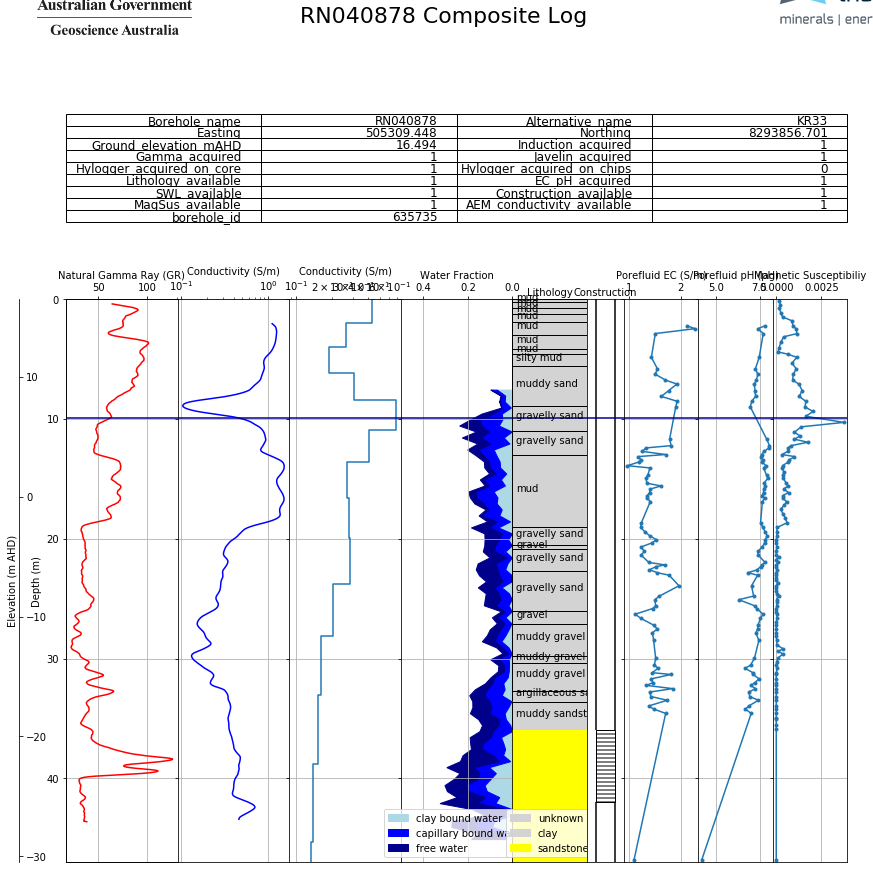

Connection to \\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite\East_Kimberley_borehole_data.sqlite is closed. Temporary working copy removed.


In [5]:
# Define the database path. Check this to ensure its up to date with the variables above.
# Variable definition applied here just so this cell runs standalone
DB_ROOT = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite"
DB_PATH = os.path.join(DB_ROOT, r"East_Kimberley_borehole_data.sqlite")

# connect to database
con = makeCon(DB_PATH)

bhid = bhname = 635735 # ENO for KR33
data = extract_all_boredata_by_simple_query(con, bhid)
drawCompLog(data)

# Close the DB connection
closeCon(con, DB_PATH)